# Compare data from Collection 3 to Collection 2 Fractional Cover
Using data from test sites.
* First, display data at test sites -done
* Then retrieve C3 data - done
* Daskify, because things are large
* Then retrieve C2 data to match -working
* Deal with clouds, and/or try and select matching scenes - we're going to have to use collection3 fmask to mask collection 2 fractional cover, as no collection 2 available on the sandbox
* Plot against each other and against NBART
* Regress the two against each other to see the differences?

In [85]:
%matplotlib inline

from copy import deepcopy
import cartopy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import xarray as xr

#modules for datacube
import datacube
from datacube.utils import masking
from datacube.helpers import ga_pq_fuser

# Import external functions from dea-notebooks
sys.path.append('../Scripts/')
sys.path.append('../Development_notebooks_BD/10_Scripts/')
import dea_plotting, dea_datahandling
import DEADataHandling #try and use old function to load, mask and concatenate C2 fractional cover

#ignore datacube warnings (needs to be last import statement)
import warnings
warnings.filterwarnings('ignore', module='datacube')

from odc.ui import with_ui_cbk

%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# set datacube alias (just a string with what you're doing)
dc = datacube.Datacube(app='dc-FC')

## Take a look at our dataset density

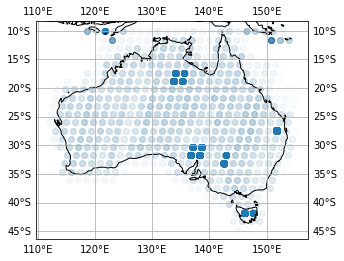

In [3]:
records = dc.find_datasets(product='ga_ls_fc_3')
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.scatter(*zip(*[(i.extent.centroid.to_crs('epsg:4326').points)[0] for i in records]), alpha =0.02)
ax.coastlines()
g = ax.gridlines(draw_labels=True); g.top_labels = g.right_labels = True
None #feed a null to jupyter environment so it doesn't print an output above our graph

define our query area + time

In [90]:
query = {'output_crs':'epsg:3577',
         'resolution':(-30,30),
         'group_by':'solar_day',
         'region_code':"090079",
         'lat':(-27.31, -27.41),
         'lon':(151.01, 151.12),
         'time':('2013-05-01', '2013-06-01'),
         'group_by' : 'solar_day'}

Check out how much data we have

In [63]:
#count the number of datasets for fc3
datasets_fc3 = dc.find_datasets(product='ga_ls_fc_3', **query)
len(datasets_fc3)

2

Load collection 3 fractional cover

In [66]:
ds_fc3 = dc.load(product='ga_ls_fc_3', **query, progress_cbk=with_ui_cbk())
print(ds_fc3)

<xarray.Dataset>
Dimensions:      (time: 2, x: 411, y: 424)
Coordinates:
  * time         (time) datetime64[ns] 2013-05-12T23:44:10.557407 2013-05-20T...
  * y            (y) float64 -3.1e+06 -3.1e+06 ... -3.112e+06 -3.112e+06
  * x            (x) float64 1.85e+06 1.85e+06 1.85e+06 ... 1.862e+06 1.862e+06
    spatial_ref  int32 3577
Data variables:
    bs           (time, y, x) uint8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    pv           (time, y, x) uint8 48 45 45 47 50 46 45 ... 23 23 23 22 23 23
    npv          (time, y, x) uint8 53 56 56 53 51 55 56 ... 78 78 78 79 78 78
    ue           (time, y, x) uint8 5 5 5 5 5 5 5 5 5 5 ... 5 5 5 5 5 5 5 5 5 5
Attributes:
    crs:           epsg:3577
    grid_mapping:  spatial_ref


Load collection 2 fractional cover for each satellite separately

for collection 2 query, remove the 'region' setting from the dictionary as it doesn't exist in collection 3. This is useful to find the datasets for collection 2.

In [114]:
query_c2 = deepcopy(query) #copy original query to second dictionary
query_c2.pop('region_code', None) #remove region code from c2 query
None #don't print results

In [115]:
#count the number of datasets for fc2 ls5
datasets_ls5_fc2 = dc.find_datasets(product='ls5_fc_albers', **query_c2)
print(len(datasets_ls5_fc2))
#count the number of datasets for fc2 ls7
datasets_ls7_fc2 = dc.find_datasets(product='ls7_fc_albers', **query_c2)
print(len(datasets_ls7_fc2))
#count the number of datasets for fc2 ls8
datasets_ls8_fc2 = dc.find_datasets(product='ls8_fc_albers', **query_c2)
print(len(datasets_ls8_fc2))

0
2
4


Load and concatenate fractional cover for collection 2 data

In [117]:
if datasets_ls5_fc2:
    print(f'loading {len(datasets_ls5_fc2)} ls5 fc c2')
    ds_fc2_5 = dc.load(product = 'ls5_fc_albers', like = ds_fc3, progress_cbk=with_ui_cbk())
if datasets_ls7_fc2:    
    print(f'loading {len(datasets_ls7_fc2)} ls7 fc c2')
    ds_fc2_7 = dc.load(product = 'ls7_fc_albers', like = ds_fc3, progress_cbk=with_ui_cbk())
if datasets_ls8_fc2:  
    print(f'loading {len(datasets_ls8_fc2)} ls8 fc c2')
    ds_fc2_8 = dc.load(product = 'ls8_fc_albers', like = ds_fc3, progress_cbk=with_ui_cbk())
#combine satellite data for the three landsats into one fractional cover dataset
ds_list = []
for i in [ds_fc2_5, ds_fc2_7, ds_fc2_8]:
    if i:
        ds_list.append(i)

loading 2 ls7 fc


loading 4 ls8 fc


In [58]:
#concatenate fractional cover for ls 5, 7, 8 into one dataset
ds_fc2 = xr.concat(ds_list, dim='time')

In [55]:
#match collection 2 to collection 3 data in time
ds_fc2 = ds_fc2.where(ds_fc3)

In [57]:
ds_fc3

<xarray.Dataset>
Dimensions:      (time: 78, x: 411, y: 424)
Coordinates:
  * time         (time) datetime64[ns] 2013-01-04T23:44:28.094427 ... 2014-12...
  * y            (y) float64 -3.1e+06 -3.1e+06 ... -3.112e+06 -3.112e+06
  * x            (x) float64 1.85e+06 1.85e+06 1.85e+06 ... 1.862e+06 1.862e+06
    spatial_ref  int32 3577
Data variables:
    bs           (time, y, x) uint8 255 255 255 255 255 255 ... 31 25 19 34 7 8
    pv           (time, y, x) uint8 255 255 255 255 255 255 ... 34 41 29 23 28
    npv          (time, y, x) uint8 255 255 255 255 255 255 ... 40 39 36 69 62
    ue           (time, y, x) uint8 255 255 255 255 255 255 255 ... 9 9 11 8 6 7
Attributes:
    crs:           epsg:3577
    grid_mapping:  spatial_ref

In [ ]:
#free up memory by setting previous datasets to None
ds_fc2_5, ds_fc2_7, ds_fc2_8 = None  

### Mask out nodata values by setting NaN = 255

In [ ]:
ds = ds.where(ds!=255)

### Plot Fractional Cover and Unmixing Error Bands
Note that Unmixing Error is high over water

In [ ]:
#just a scene we want to plot - this can be done other ways
scene = 0

In [ ]:
#set up our images on a grid using gridspec
plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2,2) # set up a 2 x 2 grid of 4 images for better presentation

ax1=plt.subplot(gs[0,0])
ds.pv.isel(time=scene).plot(cmap='gist_earth_r')
ax1.set_title('PV')

ax2=plt.subplot(gs[1,0])
ds.bs.isel(time=scene).plot(cmap='Oranges')
ax2.set_title('BS')

ax3=plt.subplot(gs[0,1])
ds.npv.isel(time=scene).plot(cmap='copper')
ax3.set_title('NPV')

ax4=plt.subplot(gs[1,1])
ds.ue.isel(time=scene).plot(cmap='magma')
ax4.set_title('UE')

plt.tight_layout()
plt.show()

### We could filter using the unmixing error, but using WOfS is more robust.

In [ ]:
#this image shows that you can filter using unmixing error if you wish
plt.figure(figsize=(12,8))
ds.ue.where(ds.ue<=20.0).isel(time=scene).plot(cmap='gist_earth_r')
ax1.set_title('UE filtered')

## Filter fractional cover scenes using WOfS feature layers (WOFLs) 
- Use the wofs dataset to create scene-by-scene masks to remove areas of water
- For more information on WOfS, see the [DEA WOfS and Water Classifier Notebook](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/Image_classification/DEA_WOfS_and_water_classifier.ipynb)
- There may be errors in the WOfS tiles until WOfS is finished 

### load the wofs feature layers (wofls) within the same query as Fractional cover, using 'like'

In [ ]:
#load the wofs feature layers (wofls) within the same query as Fractional cover, using 'like'
wofls = dc.load(product = 'ga_ls_wofs_3 ', like=ds)

### Two ways of displaying what the values in the wofs data mean:
WOfS uses [bit flags](http://datacube-core.readthedocs.io/en/latest/dev/api/masking.html) to flag pixels as 'wet' or otherwise

In [ ]:
masking.describe_variable_flags(wofls, with_pandas=True)

In [ ]:
for key in wofls.water.flags_definition.keys():
    print('{}  {}'.format(key, wofls.water.flags_definition[key]))

### Here is what the WOFL mask looks like on one timestep:

In [ ]:
wetwofl = masking.make_mask(wofls, wet=True)
wetwofl.water.isel(time=0).plot()
#drywofl = masking.make_mask(wofls, dry=True)
#drywofl.water.isel(time=0).plot()

In [ ]:
#match WOFL times to our fractional cover times
unwofld = ds.where(ds.time == wetwofl.time)
#mask out water from fractional cover
unwofld = unwofld.where(wetwofl.water==False)

### Here is what Fractional Cover looks like with WOFL removed:

In [ ]:
unwofld.PV.isel(time=0).plot()

### Edit save file path to choose where to save your output files

In [ ]:
#save files to your home directory (add your outpath here if you want to change it)
savefilepath = os.path.expanduser('~/')

## Save Fractional Cover scenes to NetCDF


In [ ]:
try:
    DEADataHandling.write_your_netcdf(unwofld, 'FC25', savefilepath+'FC25'+'.nc', crs = ds.crs)
#complain if the file already exists but don't fail    
except RuntimeError as err:
    print("RuntimeError: {0}".format(err))
print('wrote to netCDF' )

## Save Fractional Cover scenes to GeoTIFF


In [ ]:
ds = unwofld
#write a geotiff to file for each timestep
if len(ds.time)==1:
    print('one timestep')
    #drop the time dimension for only one timestep
    #write the dataset without the data percentage to file
    ds1 = ds.squeeze()
    ds1 = ds1.drop('data_perc')
    write_geotiff(savefilepath+'FC25_'+'.tif', ds1)

elif len(ds.time)>1:
    print('multiple timesteps') 
    #remove data percentage as it breaks the geotiff writer
    ds = ds.drop('data_perc')
    for timestep in range(len(ds.time)):
        try:
            write_geotiff(savefilepath+'FC25_'+str(timestep)+'.tif', ds.isel(time =timestep))
            #complain if the file already exists but don't fail    
            print('wrote to GeoTIFF' )
        except RuntimeError as err:
            print("RuntimeError: {0}".format(err))

## References
1. GA, 2015. *Fractional Cover (FC25) Product Description.* https://d28rz98at9flks.cloudfront.net/79676/Fractional_Cover_FC25_v1_5.PDF

2. TERN Auscover, 2012. *Fractional cover - Landsat, Joint Remote Sensing Research Program algorithm, Australia coverage.* Last modified by Peter Scarth on 2017/03/24 09:53. http://data.auscover.org.au/xwiki/bin/view/Product+pages/Landsat+Fractional+Cover